In [6]:
from urllib.parse import urljoin
import requests
import numpy as np

class RelativeSession(requests.Session):
    def __init__(self, base_url):
        super(RelativeSession, self).__init__()
        self.__base_url = base_url

    def request(self, method, url, **kwargs): 
        url = urljoin(self.__base_url, url)
        return super(RelativeSession, self).request(method, url, **kwargs)

#API_SITE = 'https://api.rebench.vatoth.dev/'
API_SITE = "http://rebench-api:3000"
session = RelativeSession(API_SITE)


sources = session.get("/sources?commitid=b3d66873c97cac6d4e2f79e8b6a91e3397161b62").json()
source = sources[0]
trials = session.get("/sources/{0}/trials".format(source['id'])).json()
trial = trials[2]
measurements = session.get("/trials/{0}/measurements".format(trial['id'])).json()
criterion = session.get("/criterions/{0}".format(measurements[0]['criterion'])).json()
run = session.get("/runs/{0}".format(measurements[0]['runid'])).json()
benchmark = session.get("/benchmarks/{0}".format(run['benchmarkid'])).json()
executor = session.get("/executors/{0}".format(run['execid'])).json()
environment = session.get("/environments/{0}".format(trial['envid'])).json()
experiment = session.get("experiments/{0}".format(trial['expid'])).json()
project = session.get("/projects/{0}".format(experiment['projectid'])).json()

measurements_values = np.array(list(map(lambda x: x['value'], measurements)))
measurements_values

    

array([437.182, 470.011, 485.595, ..., 160.28 , 155.505, 158.315])

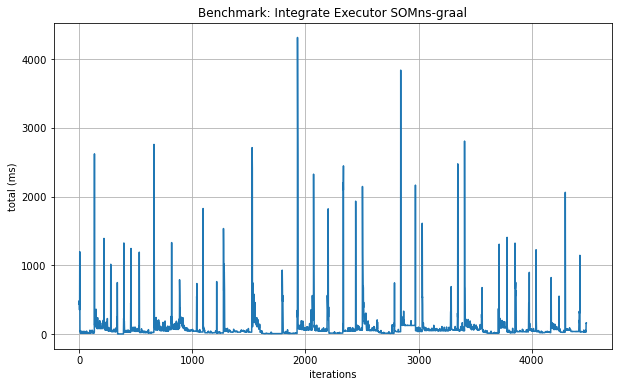

In [7]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.plot(measurements_values)

ax.set(xlabel='iterations', ylabel='{0} ({1})'.format(criterion['name'], criterion['unit']),
       title='Benchmark: {0} Executor {1}'.format(benchmark['name'], executor['name']))
ax.grid()

plt.show()


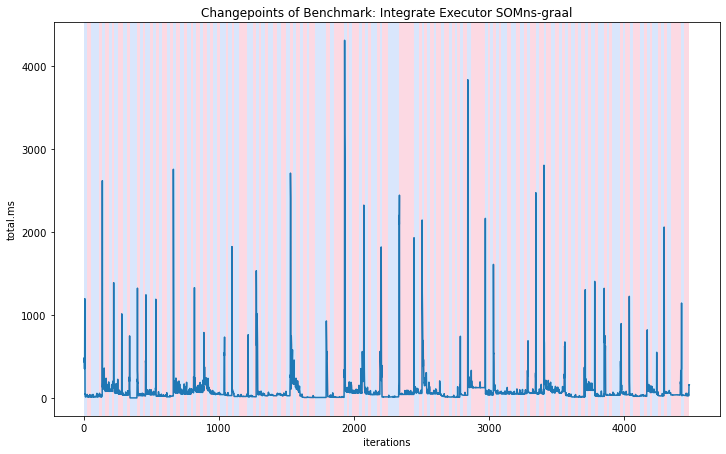

In [8]:
import ruptures as rpt

breakpoints = rpt.Pelt(model="l1", min_size=20, jump=5).fit_predict(measurements_values, 3)


fig, (ax,) = rpt.display(measurements_values, breakpoints, figsize=(10, 6))
ax.set(xlabel='iterations', ylabel='{0}.{1}'.format(criterion['name'], criterion['unit']),
       title='Changepoints of Benchmark: {0} Executor {1}'.format(benchmark['name'], executor['name']))
plt.show()

In [9]:
means = []
measurements_values_matrix = np.split(measurements_values, breakpoints)
print(len(measurements_values_matrix))
for measurements_values_split in measurements_values_matrix:
    if measurements_values_split.size > 0:
        mean = np.mean(measurements_values_split)  
        means.append(mean)
means = np.array(means)
print(means)

153
[200.87564     19.229       19.30213333  25.53848    279.37355
 115.60563333  92.73195    208.19595     87.61406667 104.43425714
  39.8581     112.7897       9.83641818 151.2644      35.6158
  36.4081     133.89168571  45.39525    123.44624     27.61575
  27.8644      25.52225     15.23495     22.07964    434.34535
 106.64897143  65.99456     90.6601      62.74213333  72.844
 205.82555     95.59736667  89.38385    227.72985714 114.7695
  63.1048      50.22546667  53.07995     89.18537778  35.80065
  29.74292    165.1259      22.08848571  19.71583636  39.92162222
  15.70176    484.5249      52.9194      39.69224     28.33308
  38.989       28.43656667  45.5733      37.010125    27.55548
 589.28908    192.6968     123.53166667  26.50735      7.09416667
   8.69225      7.2173      16.64989412 203.36472     17.47843333
   9.46358667 809.12075     87.0881     108.03035     74.39421818
  83.62185    455.0581      74.58905     56.024       45.98071111
  49.53715    356.9341      13.525266

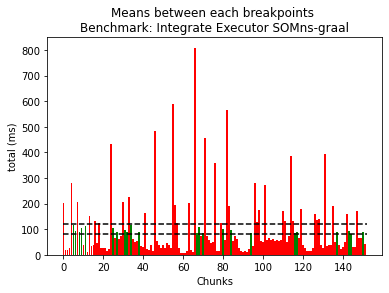

In [6]:
def percentage(percent, whole):
  return (percent * whole) / 100.0

threshold = np.mean(means)
min_threshold = threshold - percentage(20, threshold)
max_threshold = threshold + percentage(20, threshold)


x = range(len(means))

clrs = ['green' if (x < max_threshold) and (x > min_threshold) else 'red' for x in means ]


fig, ax = plt.subplots()
ax.bar(x, means, color=clrs)

ax.set(xlabel='Chunks', ylabel='{0} ({1})'.format(criterion['name'], criterion['unit']),
       title='Means between each breakpoints \nBenchmark: {0} Executor {1}'.format(benchmark['name'], executor['name']))


ax.plot([0., len(means)], [max_threshold, max_threshold], "k--")
ax.plot([0., len(means)], [min_threshold, min_threshold], "k--")




plt.show()

